![](pics/header.png)

# Mono-Camera Calibration

Kevin J. Walchko, Phd

21 Dec 2020

---

# Pinhole Camera Model

The functions in this section use a so-called pinhole camera model. In this model, a scene view is formed by projecting 3D points into the image plane using a perspective transformation.

![Pinhole Camera Model](pics/pinhole_camera_model.png)

\begin{eqnarray}
  s p' = K[R|t]P' \\
  s \begin{bmatrix} u\\ v\\ 1 \end{bmatrix} = 
  \begin{bmatrix}
    f_x & a & c_x \\
    0 & f_y & c_y \\
    0 & 0 & 1
  \end{bmatrix}
  \begin{bmatrix} R_{3x3} & t_{xyz} \end{bmatrix}
  \begin{bmatrix} X \\ Y \\ Z \\ 1 \end{bmatrix}
\end{eqnarray}


where:

- $P(X, Y, Z)$ are the coordinates of a 3D point in the world coordinate space
- $p(u, v)$ are the coordinates of the projection point in pixels
- $K$ is a camera matrix, or a matrix of **intrinsic** parameters (think internal parameters)
- ($c_x$, $c_y$) is a principal point that is usually at the image center
- $f_x$, $f_y$ are the focal lengths expressed in pixel units
- $[R|t]$ are the **extrinsic** parameters (think external parameters)
- $a$ is a skewing parameter that transforms square pixels into parallograms. Note, this is only a simple skewing in 1 parameter, it can effect all off diagional terms in the top, left 3x3.

The matrix of intrinsic parameters does not depend on the scene viewed. So, once estimated, it can be re-used as long as the focal length is fixed (in case of zoom lens). The joint rotation-translation matrix [R|t] is called a matrix of extrinsic parameters. It is used to describe the camera motion around a static scene. That is, [R|t] translates coordinates of a point (X, Y, Z) to a coordinate system, fixed with respect to the camera. The transformation above is equivalent to the following (when $z \ne 0$ ):

\begin{eqnarray}
  \begin{bmatrix} x \\ y \\ z \end{bmatrix}^{camera} = R_{3x3}
  \begin{bmatrix} X \\ Y \\ Z \end{bmatrix}^{world} + t_{xyz} \\
  x' = \frac{x}{z} \\
  y' = \frac{y}{z} \\
  u = f_x*x'+c_x \\
  v = f_y*y'+c_y
\end{eqnarray}

where (X,Y,Z) are world space coordinates with units of meters, (x,y,z) are rotated/translated to the camera's coordinate system with units of meters, (x',y') are normalized (divided by z, these are unitless) in the camera's FOV, and (u,v) are finally projected onto the camera's image plane with units of pixels. 


## Focal Length

![](pics/fov-eqn.png)

The focal length of a camera is an important aspect for a couple of reasons.

1. A properly designed camera has a focal length which ensures your entire image plane is illuminated with light
1. Your focal length also determines your field of view.

$$
\alpha = 2 \cdot arctan2(w, 2f) \\
f = \frac{w}{2} \cot( \frac{\alpha}{2} )
$$

A lot of cameras have a fixed focal length, like our cell phone camera used with the raspberry pi, but some cameras have a mechanical zoom feature which narrows the FOV and allow more pixels across a smaller area.

All cameras have a digital zoom, where they smartly average pixels together to simulate a mechanical zoom, but it really isn't a zoom. You are better off taking the native image and then "zooming" and cropping the image in software later.

## Distortions

If everything was perfect, the red lines in the image below would lie neatly on the checkerboard.

![](pics/distortion.jpg)

However, there are always little distortions in the lense (or misalignments) that break this model. Typically you must correct for radial ($k_{1-6}$) and tangential ($p_{1-2}$) distortions coefficients which effect the $x'$ and $y'$ terms in a nonlinear manor. The pictures below show the barrel distortion (typically $k_1 > 0$) and pincushion distortion (typically $k_1 < 0$).

![](pics/distortion_examples.png)


## Calibration

![](pics/cal-images.jpg)

So how do we do this? The calibration code for the checkerboard does:

1. Converts image to grayscale
1. Searches for the intersections of the chessboard and should find 9x6 of them (i.e., 54 intersections)
1. Using homography and knowing that we are using a chessboard, it then uses an algorithm, typically RANSAC, to figure out the how the calibration target was warped in order to match the image.
    1. Note, there are other camera targets besides the classic chessboard: circular grids, apriltags, AruCo tags, ChAruCo tags, etc.
    1. Chessboard and any other pattern that has corner intersections, perform better than trying to estimate the center of a circle
1. It then returns your calculated camera matrix and distortion parameters (the k's mentioned above) which allow you to remove distortion from an image

## Calibration Patterns

OpenCV supports several patterns:

| Checkerboard | Symetric Circles | Asymetric Circles |
|--------------|------------------|-------------------|
|![](pics/checkerboard.jpg)|![](pics/symetric-circles2.jpg)|![](pics/asymetric-circles.jpg)|

Generally, the checkerboard pattern performs the best. Mainly because the algorithms are simple and effective to finding the intersections of the black/white squares. The circles use a more complex algorithm and have to determine the center of mass correctly. Unfortunately, camera lens distortion can cause the centers to be off just a little and the calibration not as good as the checkerboard.

<img src="pics/intersection.png" width="30%">

## Performance

How do you know you did a good job? The function `cv2.calibrateCamera()` returns an RMS value in pixels, so:

- **BAD:** RMS > 1.0px
- **OK:** RMS < 1.0px
- **GOOD:** RMS < 0.5px

However, RMS is necessary but not sufficient for good calibration. Low RMS means the algorithm was able to minimize the objective function on the given inputs **on average**. You need to look at the global results (i.e., image per image, corner per corner) to see how it performs. Thus, you will typically see people reproject the points using the new calibration matrix and then calculating the error from that.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
np.set_printoptions(precision=2)
np.set_printoptions(suppress=True)

import cv2

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10) # set default figure width

# from slurm import storage
# from pprint import pprint
from pathlib import Path

In [3]:
from opencv_camera import CameraCalibration
from opencv_camera import drawHorizontalLines
from opencv_camera import ChessboardFinder
from opencv_camera import UnDistort
from opencv_camera import bgr2gray, gray2bgr
from opencv_camera import coverage, mosaic
from opencv_camera import visualizeDistortion
from opencv_camera import computeReprojectionErrors, visualizeReprojErrors

In [4]:
def readImages(path, pattern):
    p = Path(path).glob(pattern)
    p = list(p)
    p.sort()
    return [cv2.imread(str(f),0) for f in p]

imgs = readImages("cal_pics","left*.jpg")
print(f">> Found {len(imgs)} images")

>> Found 13 images


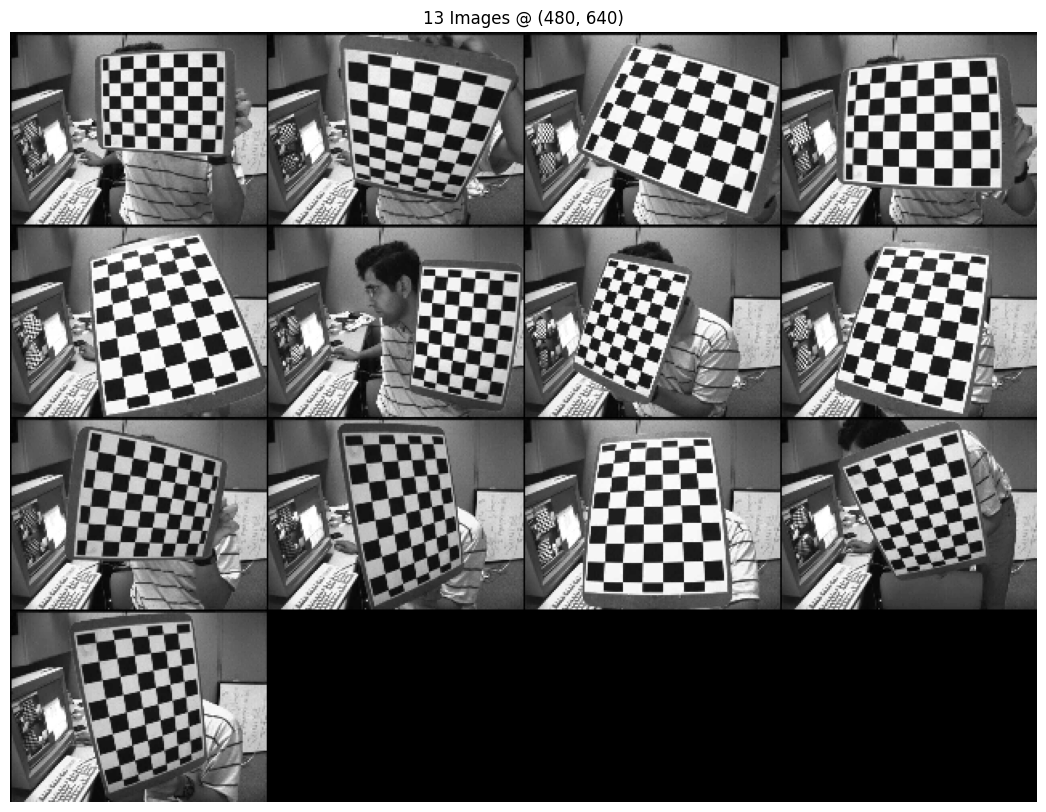

In [5]:
# a simple mosasic of the various images
plt.imshow(mosaic(imgs, width=4), cmap="gray")
plt.title(f"{len(imgs)} Images @ {imgs[0].shape}")
plt.axis("off");

In [6]:
help(CameraCalibration.calibrate)

Help on function calibrate in module opencv_camera.mono.calibrate:

calibrate(self, images, board, flags=None)
    images: an array of grayscale images, all assumed to be the same size.
        If images are not grayscale, then assumed to be in BGR format.
    board: an object that represents your target, i.e., Chessboard
    marker_scale: how big are your markers in the real world, example:
        checkerboard with sides 2 cm, set marker_scale=0.02 so your T matrix
        comes out in meters



In [22]:
calibrator = CameraCalibration()
board = ChessboardFinder((6,9), 1)

cam, cal = calibrator.calibrate(imgs, board)

>> RMS: 0.195px

 Camera[480,640]----------------------
  focalLength(x,y): 532.8 532.9 px 
  principlePoint(x,y): 342.5 233.9 px
  distortionCoeffs: [[-0.281  0.025  0.001 -0.     0.163]]



In [8]:
# lets see what is in the returned dictionary
cal.keys()

dict_keys(['date', 'markerType', 'markerSize', 'imageSize', 'K', 'd', 'rms', 'rvecs', 'tvecs', 'objpoints', 'imgpoints', 'badImages', 'stdint', 'stdext', 'perViewErr'])

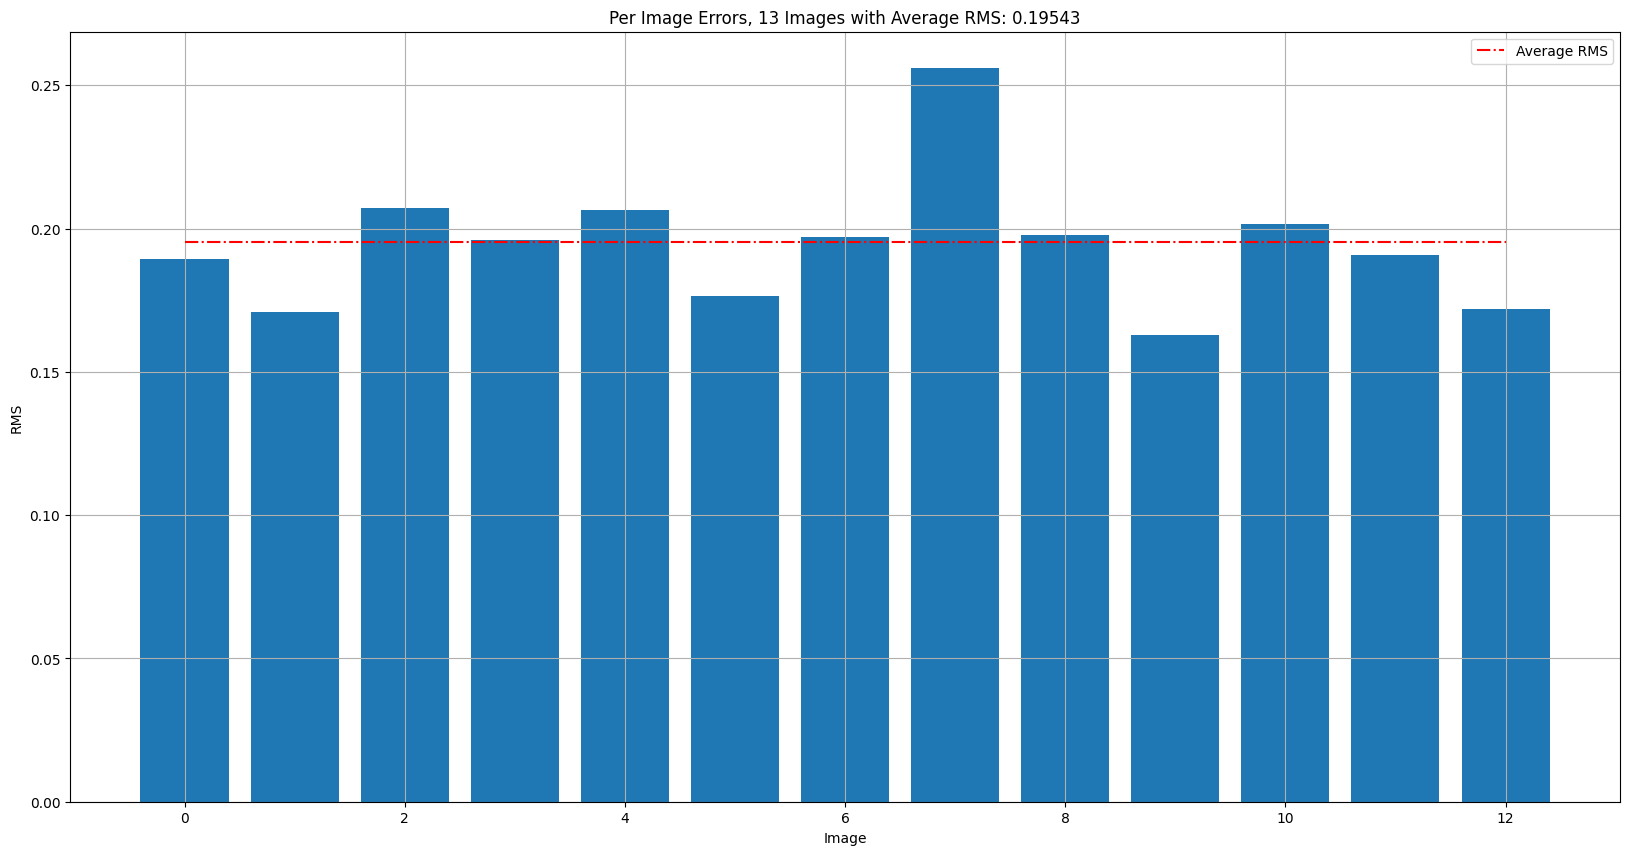

In [11]:
err = cal["perViewErr"].ravel()
plt.bar(range(len(err)), err)
plt.plot(np.ones(len(err))*cal["rms"], "r-.", label="Average RMS")
plt.grid(True)
plt.legend()
plt.ylabel("RMS")
plt.xlabel("Image")
plt.title(f"Per Image Errors, {len(err)} Images with Average RMS: {cal['rms']:0.5f}");

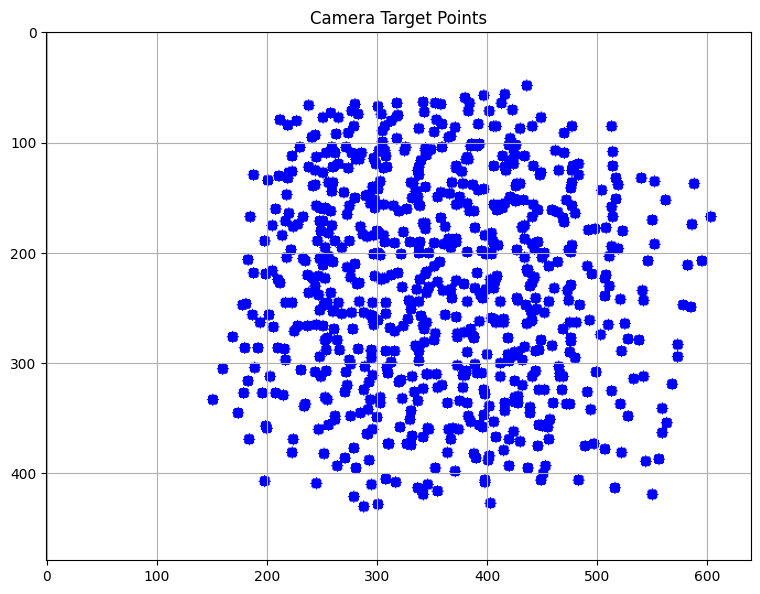

In [12]:
# let's plot where every corner was detected. Notice
# we are not testing the edges of the camera! That 
# is where a lot of distortion occurs from low quality
# lenses. Ideally, you want better coverage.
plt.subplot(1,2,1)
ip = cal["imgpoints"]
icv = coverage((480, 640), ip)
plt.imshow(icv)
plt.grid(True)
plt.title("Camera Target Points");

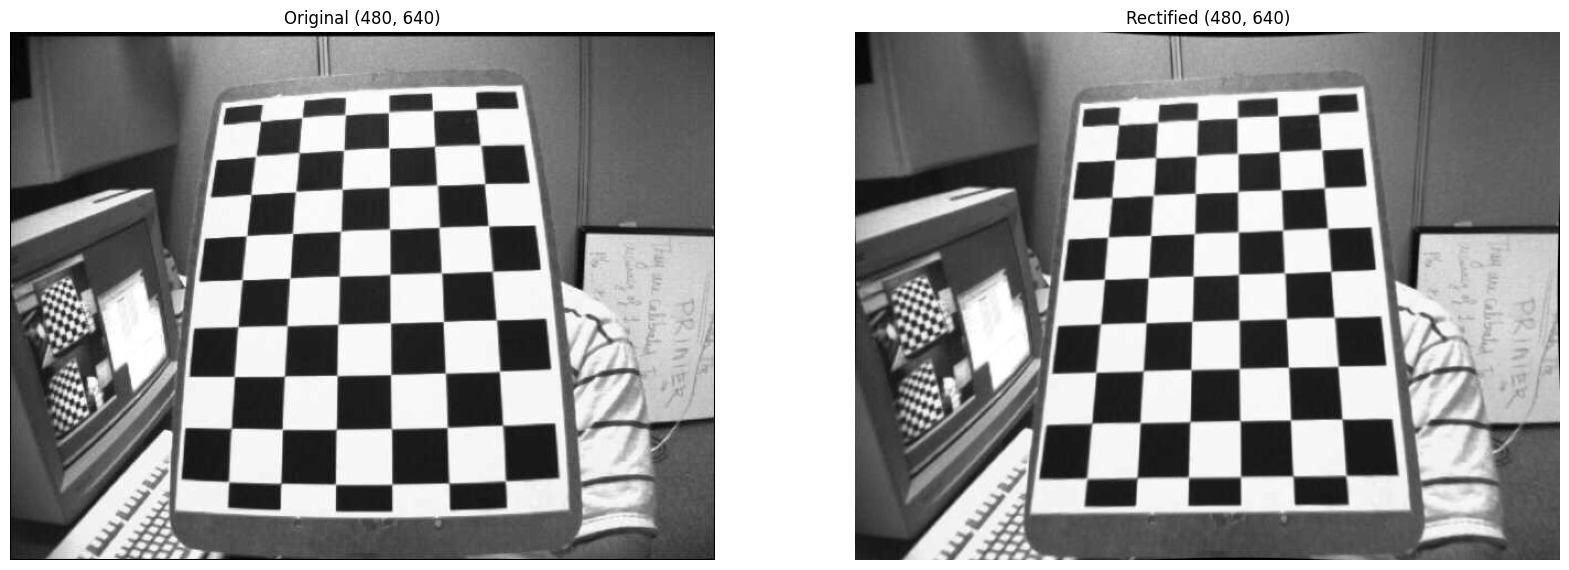

In [16]:
# let's use this info to rectify the image
# ud = UnDistort(cal["K"], cal["d"], 480, 640)
ud = cam.getUndistortion()

im = imgs[10]
corr = ud.undistort(im)

plt.subplot(1,2,1)
plt.imshow(im, cmap="gray")
plt.title(f"Original {im.shape}");plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(corr, cmap="gray")
plt.title(f"Rectified {corr.shape}");plt.axis("off");

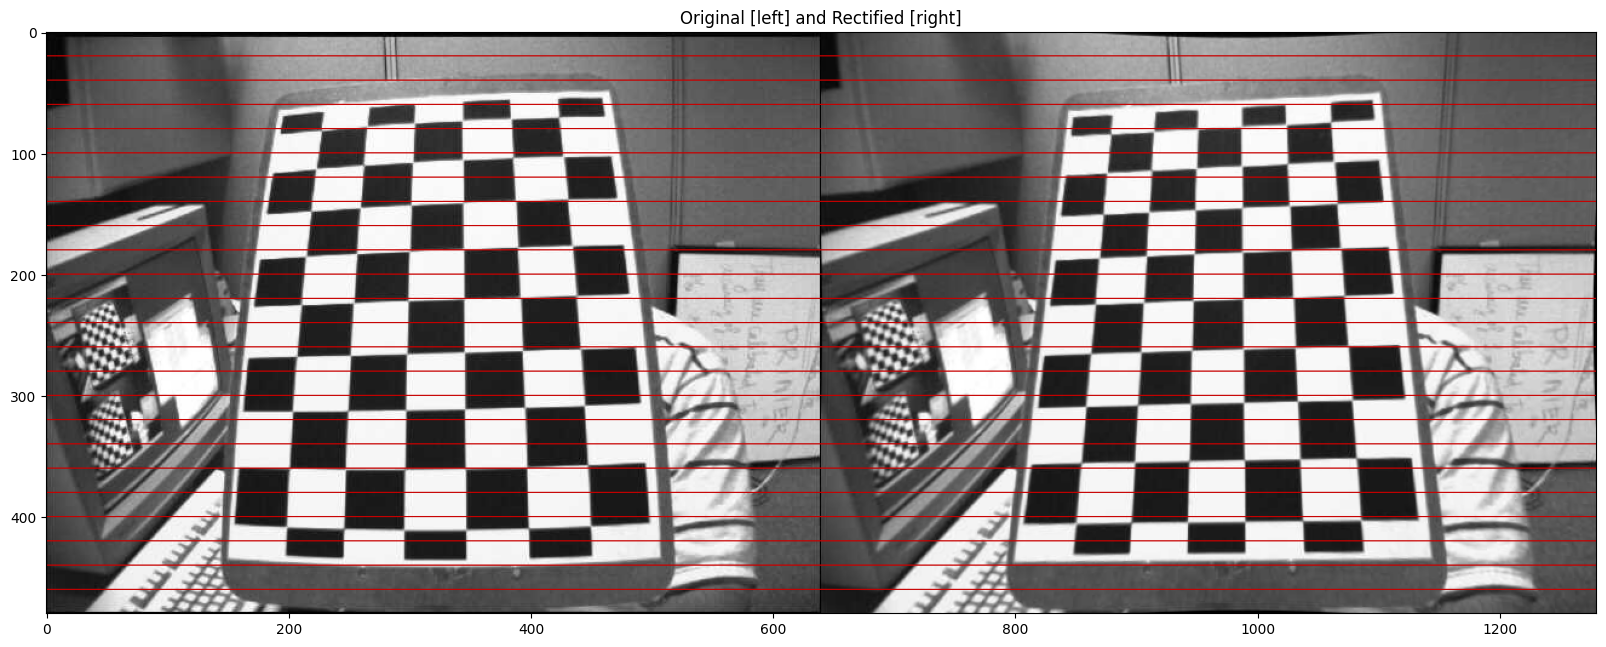

In [17]:
# Maybe the lines will help show the barrel distorition correction 
# a little better. Hopefully, the chessboad lines look straighter in 
# the right image than the original left image.
ep = drawHorizontalLines(im,corr, thickness=1)
plt.imshow(ep)
plt.title("Original [left] and Rectified [right]");

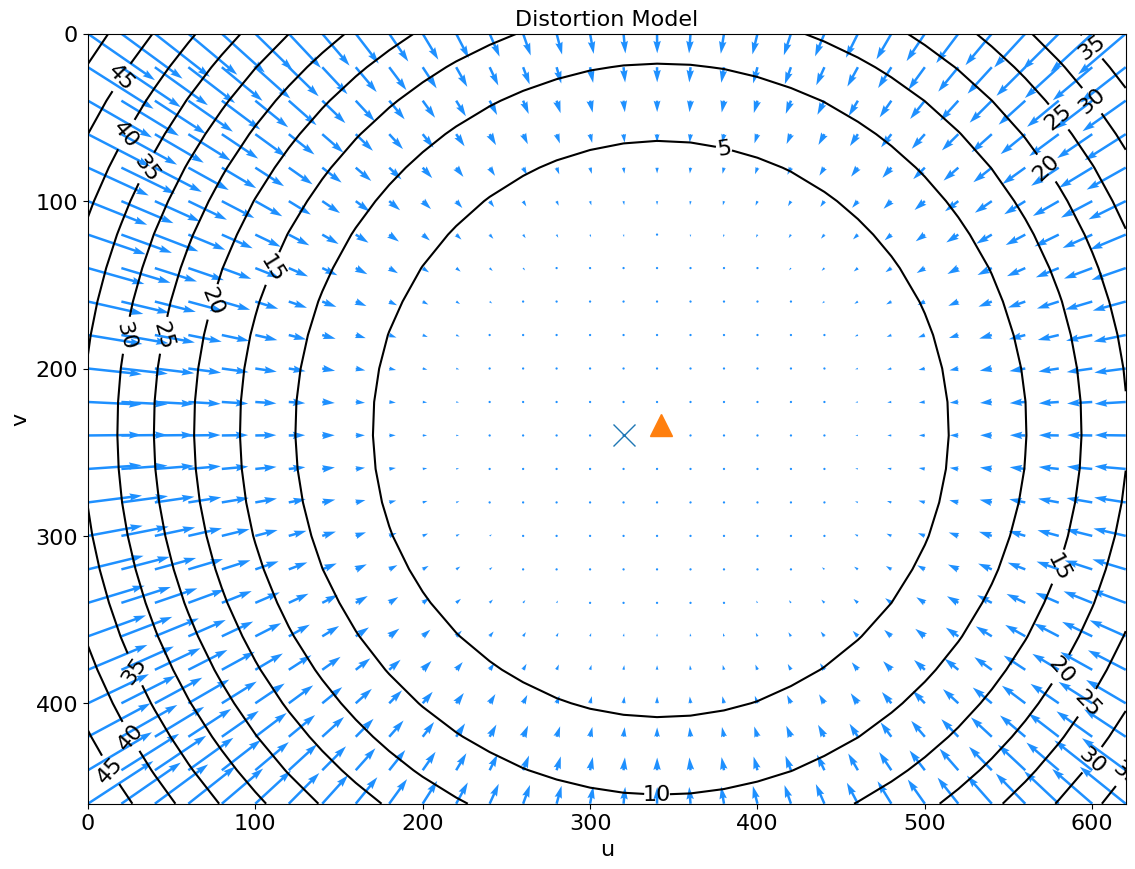

In [18]:
visualizeDistortion(cam.K, cam.d,480,640)

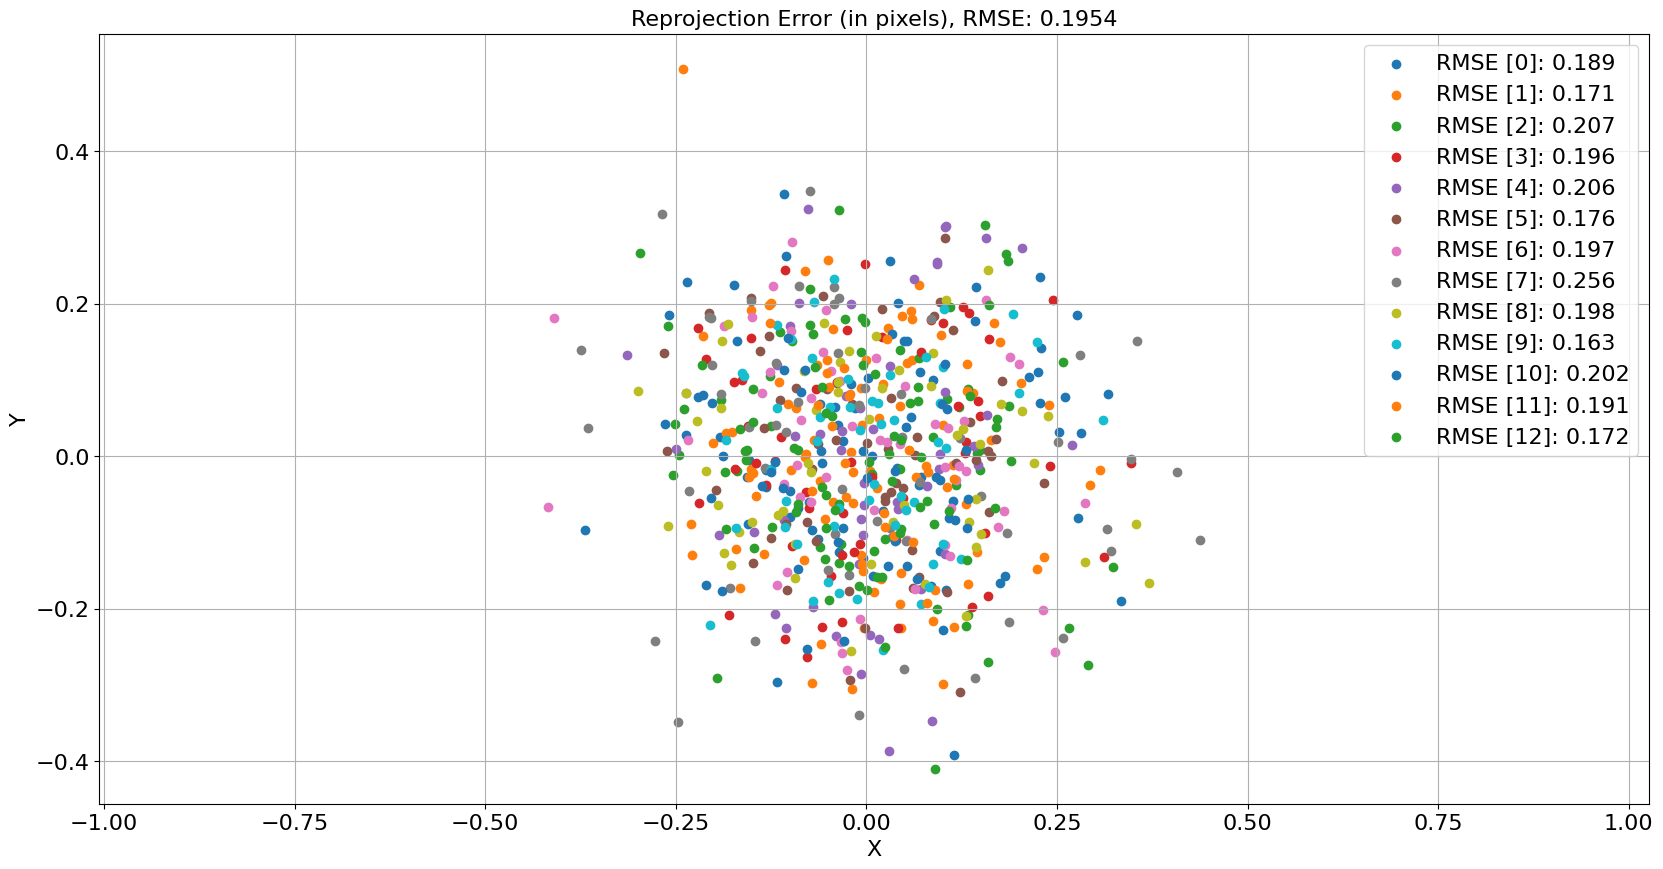

In [19]:
em,rms,xy = computeReprojectionErrors(
    cal["imgpoints"], cal["objpoints"], 
    cal["rvecs"], cal["tvecs"], 
    cal["K"], cal["d"])

visualizeReprojErrors(em, rms, xy,legend=True)

# Save Parameters

So we don't have to run this again, let's save this. I am going to use `pickle`, which is python only, to save the data. This format is not portable to C++ or any other language, but I am only concerned with python. 

In [25]:
cam.to_yaml("camera.yml")

In [26]:
!cat camera.yml

K:
- - 532.827107119106
  - 0.0
  - 342.4867854366279
- - 0.0
  - 532.9458859258712
  - 233.85594816018178
- - 0.0
  - 0.0
  - 1.0
d:
- - -0.2808809101415444
  - 0.025171657577334812
  - 0.0012165734631377511
  - -0.0001355494073857727
  - 0.1634489103187857
h: 480
w: 640
